## Problem 1 - Predicting Churn - Classification Problem

Use Churn.xls file (provided on GitHub) to predict Customer churn. Data should be transformed whenever necessarily. Make sure to tune all 4 models (including Logistic Regression) to achieve best possible result for each according to carefully selected evaluation metric.

Note: make sure to normalize (scale with max or standardize) inputs in both tasks and observe potential change in results.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.metrics import recall_score, roc_auc_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [2]:
churn_raw = pd.read_excel("https://github.com/HrantDavtyan/BA_BA/blob/master/Churn.xls?raw=true")

In [3]:
churn_raw.head(2)

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,...,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,...,45.07,99,16.78,91,11.01,3,2.7,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,...,27.47,103,16.62,103,11.45,3,3.7,OH,415,371-7191


In [4]:
churn_raw.info()
#I will transform the data before applying models
#It is important to note that there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Eve Mins          3333 non-null float64
Night Mins        3333 non-null float64
Intl Mins         3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
State             3333 non-null object
Area Code         3333 non-null int64
Phone             3333 non-null object
dtypes: float64(8), int64(11), object(2)
memory usage: 546.9+ KB


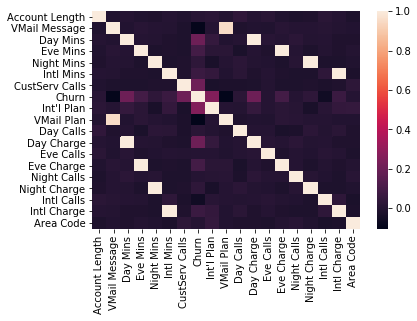

In [5]:
churn_no_object = churn_raw.select_dtypes(exclude=["object"])
sns.heatmap(churn_no_object.corr())
plt.show()

In [6]:
#Benchmarking
churn_raw.Churn.value_counts()/len(churn_raw)*100

0    85.508551
1    14.491449
Name: Churn, dtype: float64

In [7]:
churn_raw[['Day Mins','Day Charge']].corr(method='pearson', min_periods=1)
#This means that 'Day Mins' and 'Day Charge columns are perfectly correlated, 
#So we can drop 'Day Mins' column.

,Day Mins,Day Charge
Day Mins,1.0,1.0
Day Charge,1.0,1.0


In [8]:
churn_raw[['Eve Mins','Eve Charge']].corr(method='pearson', min_periods=1)
#This means that 'Eve Mins' and 'Eve Charge columns are perfectly correlated, 
#So we can drop 'Eve Mins' column.

,Eve Mins,Eve Charge
Eve Mins,1.0,1.0
Eve Charge,1.0,1.0


In [9]:
churn_raw[['Night Mins','Night Charge']].corr(method='pearson', min_periods=1)
#This means that 'Night Mins' and 'Night Charge columns are perfectly correlated, 
#So we can drop 'Night Mins' column.

,Night Mins,Night Charge
Night Mins,1.000000,0.999999
Night Charge,0.999999,1.000000


In [10]:
churn_raw[['VMail Message','VMail Plan']].corr(method='pearson', min_periods=1)
#I consider to drop 'VMail Message' column also, 
#However I will reconsider this choice after developing models. 

,VMail Message,VMail Plan
VMail Message,1.000000,0.956927
VMail Plan,0.956927,1.000000


In [11]:
churn_raw[['Intl Mins','Intl Charge']].corr(method='pearson', min_periods=1)
#This means that 'Intl Mins' and 'Intl Charge' columns are perfectly correlated,
#So we can drop 'Night Mins' column. 

,Intl Mins,Intl Charge
Intl Mins,1.000000,0.999993
Intl Charge,0.999993,1.000000


In [12]:
#Besides above mentioned columns, I will also drop 'State', 'Area Code' and 'Phone Number' columns, since those
#do not make sense in the churn analysis. 
churn_clear = churn_raw.drop(['State','Area Code','Phone','Day Charge','Eve Charge',
                              'Night Charge','Intl Charge'], axis=1)
churn_clear.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,Day Calls,Eve Calls,Night Calls,Intl Calls
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,99,91,3
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,103,103,3
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,110,104,5
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,88,89,7
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,122,121,3


In [13]:
#train test split and x,y estimation
y = churn_clear.Churn
x = churn_clear.drop("Churn",axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [14]:
#Modals with default parameters and unscaled data
model_tree = DecisionTreeClassifier(random_state=42)
model_logit = LogisticRegression(random_state=42)
model_rf = RandomForestClassifier(random_state=42)
model_gb = GradientBoostingClassifier(random_state=42)
model_tree.fit(x_train,y_train)
model_logit.fit(x_train,y_train)
model_rf.fit(x_train,y_train)
model_gb.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [15]:
#Accuracy scores on train and test sets
print(model_tree.score(x_train,y_train)*100)
print(model_logit.score(x_train,y_train)*100)
print(model_rf.score(x_train,y_train)*100)
print(model_gb.score(x_train,y_train)*100)
print(model_tree.score(x_test,y_test)*100)
print(model_logit.score(x_test,y_test)*100)
print(model_rf.score(x_test,y_test)*100)
print(model_gb.score(x_test,y_test)*100)

100.0
86.59463785514205
99.15966386554622
97.1188475390156
90.40767386091127
85.13189448441247
93.04556354916068
94.36450839328538


In [16]:
#MSE's for default parameter models
tree_pred = model_tree.predict(x_test)
logit_pred = model_logit.predict(x_test)
rf_pred = model_rf.predict(x_test)
gb_pred = model_gb.predict(x_test)
print(mean_squared_error(y_test,tree_pred))
print(mean_squared_error(y_test,logit_pred))
print(mean_squared_error(y_test,rf_pred))
print(mean_squared_error(y_test,gb_pred))

0.09592326139088729
0.1486810551558753
0.06954436450839328
0.05635491606714628


In [17]:
#roc auc scores for default parameter models
print(roc_auc_score(y_test,tree_pred)*100)
print(roc_auc_score(y_test,logit_pred)*100)
print(roc_auc_score(y_test,rf_pred)*100)
print(roc_auc_score(y_test,gb_pred)*100)

83.48547249647392
55.67165021156559
78.1179125528914
84.16530324400564


In [18]:
#recall scores for default parameter models
print(recall_score(y_test,tree_pred)*100)
print(recall_score(y_test,logit_pred)*100)
print(recall_score(y_test,rf_pred)*100)
print(recall_score(y_test,gb_pred)*100)

73.6
13.600000000000001
56.8
69.6


In [19]:
#cv's for default parameter models
print(cross_val_score(model_tree,x,y,cv=10))
print(cross_val_score(model_logit,x,y,cv=10))
print(cross_val_score(model_rf,x,y,cv=10))
print(cross_val_score(model_gb,x,y,cv=10))

[0.90718563 0.91017964 0.93712575 0.91591592 0.91891892 0.91891892
 0.8978979  0.9039039  0.91891892 0.93693694]
[0.84431138 0.8742515  0.85928144 0.85585586 0.85585586 0.86186186
 0.87387387 0.86786787 0.86186186 0.84984985]
[0.94011976 0.94011976 0.9251497  0.92492492 0.94894895 0.93693694
 0.95195195 0.93693694 0.92792793 0.94594595]
[0.94610778 0.95209581 0.93712575 0.93993994 0.96696697 0.95195195
 0.95195195 0.94594595 0.95195195 0.96396396]


In [20]:
print(cross_val_score(model_tree,x,y,cv=10).std())
print(cross_val_score(model_logit,x,y,cv=10).std())
print(cross_val_score(model_rf,x,y,cv=10).std())
print(cross_val_score(model_gb,x,y,cv=10).std())

0.012216003471141244
0.009391524301582868
0.009090370277449748
0.008892837866680336


### Decision Tree - Tuning

In [21]:
#We can start by applying max depth for our Tree model
model_tree_9 = DecisionTreeClassifier(max_depth = 9, random_state=42)
model_tree_9.fit(x_train,y_train)
model_tree_9.score(x_train,y_train)*100
model_tree_9.score(x_test,y_test)*100
print(cross_val_score(model_tree_9,x,y,cv=10).std())
#std of cross val scores decreased slightly

0.009279164268063585


In [22]:
model_tree_9_pred = model_tree_9.predict(x_test)
print(roc_auc_score(y_test,model_tree_9_pred)*100)
print(recall_score(y_test,model_tree_9_pred)*100)
#Roc auc has improved just slightly
#We can stay with this model, 
#However we continue tuning to understand what we can achieve with the DTree

84.80112834978843
72.0


In [23]:
#Decision Tree with min leaf values
model_tree_110 = DecisionTreeClassifier(min_samples_leaf=110,random_state=42)
model_tree_110.fit(x_train,y_train)
print(model_tree_110.score(x_train,y_train)*100)
print(model_tree_110.score(x_test,y_test)*100)
print(cross_val_score(model_tree_110,x,y,cv=10).std())
#more overfit in comparison with max_depth=9 model

86.63465386154462
87.29016786570743
0.013324840300563873


In [24]:
model_tree_110_pred = model_tree_110.predict(x_test)
print(roc_auc_score(y_test,model_tree_110_pred)*100)
print(recall_score(y_test,model_tree_110_pred)*100)
#However we observe worse roc auc score

73.08547249647391
52.800000000000004


In [25]:
#I will try to balance classes for the tree 
#Further, develop a model with defailt paramteres but with balanced classes
model_tree_balanced=DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_tree_balanced.fit(x_train,y_train)
print(model_tree_balanced.score(x_train,y_train)*100)
print(model_tree_balanced.score(x_test,y_test)*100)
print(cross_val_score(model_tree_balanced,x,y,cv=10).mean())
#the model is overfitting if we compare cv scores with train score

100.0
91.12709832134293
0.9210911510312709


In [26]:
model_tree_balanced_pred= model_tree_balanced.predict(x_test)
print(roc_auc_score(y_test,model_tree_balanced_pred)*100)
print(recall_score(y_test,model_tree_balanced_pred)*100)
#roc auc score is no better than it was before 

83.57912552891396
72.8


In [27]:
#I will apply GridSearcCV to find best parameters
max_depth_values = [k for k in range(5,21)]
min_sample_values = [k for k in range(4,22,2)]
min_samples_split_values= [k for k in range(6,16,2)]

In [29]:
grid_search_dt_parameters = {"max_depth":max_depth_values, 
                             "min_samples_leaf":min_sample_values, 
                             "min_samples_split":min_samples_split_values}
grid_search_dt=GridSearchCV(model_tree_balanced,grid_search_dt_parameters)
grid_search_dt.fit(x_train, y_train)
print(grid_search_dt.best_params_)

{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 6}


In [30]:
model_tree_best = DecisionTreeClassifier(max_depth = 6, 
                                         min_samples_leaf = 4, 
                                         class_weight="balanced",
                                         min_samples_split=6, random_state=42)
model_tree_best.fit(x_train,y_train)
print(model_tree_best.score(x_train,y_train)*100)
print(model_tree_best.score(x_test,y_test)*100)
print(cross_val_score(model_tree_best,x,y,cv=10).std())

94.5578231292517
93.64508393285371
0.01871207468871563


In [31]:
model_tree_best_pred= model_tree_balanced.predict(x_test)
print(roc_auc_score(y_test,model_tree_best_pred)*100)
print(recall_score(y_test,model_tree_best_pred)*100)

83.57912552891396
72.8


In [32]:
importances = model_tree_best.feature_importances_
features = pd.DataFrame(data = importances, columns = ["importance"], 
                        index = x.columns)
features

,importance
Account Length,0.000000
VMail Message,0.031823
Day Mins,0.256993
Eve Mins,0.101036
Night Mins,0.018045
Intl Mins,0.042493
CustServ Calls,0.230034
Int'l Plan,0.227074
VMail Plan,0.006420
Day Calls,0.000000


In [33]:
selected_features = features[features.importance>0.15]
selected_features_1 = selected_features.index
x_train_new = x_train[selected_features_1]
x_test_new = x_test[selected_features_1]

In [34]:
model_tree_best.fit(x_train_new, y_train)
print(model_tree_best.score(x_train_new, y_train)*100)
print(model_tree_best.score(x_test_new, y_test)*100)

86.47458983593438
82.85371702637889


In [35]:
model_tree_best_imp_pred= model_tree_best.predict(x_test_new)
print(roc_auc_score(y_test,model_tree_best_imp_pred)*100)
print(recall_score(y_test,model_tree_best_imp_pred)*100)

77.724682651622
70.39999999999999


From the models that I observed using DT, roc auc score was the best for the model with max_depth=9 wiht other criteria default. 

### Logistic Regression - Tuning 

In [36]:
confusion_m_logit = confusion_matrix(y_test,logit_pred)
print(confusion_m_logit)
#The result is telling us that we have 693+16 correct predictions,
#107+18 incorrect predictions with the initial model.

[[693  16]
 [108  17]]


In [37]:
#I will try a logit model with specifying C
n=np.arange(0,1)
r=pow(float(10),n)
for C in r:
    model_logit_C=LogisticRegression(C=C,penalty="l2")
    model_logit_C.fit(x_train,y_train)
    print(model_logit_C.score(x_train,y_train)*100)
    print(model_logit_C.score(x_test,y_test)*100)

86.47458983593438
85.25179856115108


In [38]:
logit_C_pred = model_logit_C.predict(x_test)
print(mean_squared_error(y_test,logit_C_pred))
print(roc_auc_score(y_test,logit_C_pred)*100)
print(recall_score(y_test,logit_C_pred)*100)

0.1474820143884892
56.07165021156558
14.399999999999999


#### Logistic Regression model with normalized data 

In [39]:
#Preprocessing is imported, so I will standardize with preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
steps = [('scaler', StandardScaler()),
        ('logit', LogisticRegression())]
pipeline = Pipeline(steps)
model_logit_s = pipeline.fit(x_train, y_train)
print(model_logit_s.score(x_train,y_train)*100)

86.39455782312925


In [41]:
model_logit_s_pred= model_logit_s.predict(x_test)
print(roc_auc_score(y_test, model_logit_s_pred)*100)
print(recall_score(y_test, model_logit_s_pred)*100)
confusion_m_logit_s = confusion_matrix(y_test,model_logit_s_pred)
print(confusion_m_logit_s)
#To verify that results are the same
#in comparison with default parameters unscaled logit model, scaled logit model is better

58.801128349788435
20.0
[[692  17]
 [100  25]]


### Random Forest - Tuning

In [42]:
#Firstly we can try with best parameters from DT
model_rf_good = RandomForestClassifier(max_depth = 6, min_samples_leaf = 4,
                                       class_weight="balanced",min_samples_split=6, 
                                       random_state=42)
model_rf_good.fit(x_train, y_train)
print(model_rf_good.score(x_train,y_train)*100)
print(model_rf_good.score(x_test,y_test)*100)
print(cross_val_score(model_rf_good,x,y,cv=10).std())

94.07763105242097
93.28537170263789
0.016717154887464395


In [43]:
rf_good_pred = model_rf_good.predict(x_test)
print(roc_auc_score(y_test,rf_good_pred)*100)
print(recall_score(y_test,rf_good_pred)*100)
print(mean_squared_error(y_test,rf_good_pred))

89.13173483779971
83.2
0.0671462829736211


In [44]:
#I will apply gridsearch for this one as well.
param_grid_values = {'max_depth': [i for i in range(2,19)], 
                     'min_samples_leaf': [3,4,6,7,9,10],
                     'min_samples_split': [z for z in range(4,21,2)]}

In [45]:
grid_search_rf = GridSearchCV(estimator = model_rf,
                              param_grid = param_grid_values, 
                              scoring='roc_auc',cv=2,n_jobs=2)
grid_search_rf.fit(x_train,y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 'min_samples_leaf': [3, 4, 6, 7, 9, 10], 'min_samples_split': [4, 6, 8, 10, 12, 14, 16, 18, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
grid_search_rf.best_params_

{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 20}

In [47]:
model_rf_best_params = RandomForestClassifier(max_depth = 10, min_samples_leaf = 6, 
                                              min_samples_split = 20, random_state=42)
model_rf_best_params.fit(x_train,y_train)
print(model_rf_best_params.score(x_train,y_train)*100)
print(model_rf_best_params.score(x_test,y_test)*100)

95.03801520608243
92.80575539568345


In [48]:
model_rf_best_params_pred = model_rf_best_params.predict(x_test)
print(roc_auc_score(y_test,model_rf_best_params_pred)*100)
print(recall_score(y_test,model_rf_best_params_pred)*100)
print(mean_squared_error(y_test,model_rf_best_params_pred))

78.6358251057828
58.4
0.07194244604316546


In [49]:
confusion_m_rf_best_params = confusion_matrix(y_test,model_rf_best_params_pred)
print(confusion_m_rf_best_params)

[[701   8]
 [ 52  73]]


### Gradient Boosting - Tuning

In [50]:
gb_grid_params = {'learning_rate': [0.1,0.4,0.75],
                  'max_depth': [d for d in range(6,16,3)],
                  'min_samples_leaf': [d for d in range(5,61,15)],
                  'max_features': [0.01,0.03,0.75,0.15]}

In [51]:
model_gb_1 = GradientBoostingClassifier(random_state=42)

In [52]:
grid_search_gb =GridSearchCV(estimator=model_gb_1, param_grid = gb_grid_params,
                             cv=4, n_jobs=2)
grid_search_gb.fit(x_train,y_train)
grid_search_gb.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 0.75,
 'min_samples_leaf': 20}

In [53]:
model_gb_best_params = GradientBoostingClassifier(learning_rate=0.1, 
                                                  max_depth=6, max_features=0.75,
                                                  min_samples_leaf=20, random_state=42)
model_gb_best_params.fit(x_train,y_train)
print(model_gb_best_params.score(x_train,y_train)*100)
print(model_gb_best_params.score(x_test,y_test)*100)

98.75950380152061
95.20383693045564


In [54]:
model_gb_best_params_pred = model_gb_best_params.predict(x_test)
print(roc_auc_score(y_test,model_gb_best_params_pred)*100)
print(recall_score(y_test,model_gb_best_params_pred)*100)
print(mean_squared_error(y_test,model_gb_best_params_pred))
print(cross_val_score(model_gb_best_params,x,y,cv=10).std())
confusion_m_gb_best_params = confusion_matrix(y_test,model_gb_best_params_pred)
print(confusion_m_gb_best_params)
#we can see that roc auc score has improved in comparison with default parameters

85.64739069111424
72.0
0.047961630695443645
0.012509571451399519
[[704   5]
 [ 35  90]]


## Problem 2 - Predicting CLV - Regression Problem

Use the file (provided on GitHub) to predict Customer Lifetime Value. Again, data should be transformed whenever necessarily. Make sure to tune models to achieve best possible result for each according to carefully selected evaluation metric.

In [55]:
clv_data = pd.read_csv("https://github.com/HrantDavtyan/Business_Analytics/blob/master/CLV.csv?raw=true")

In [56]:
clv_data.head(3)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


In [57]:
clv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               

In [58]:
#We have to encode categories
#encoding categories for ordered columns
clv_data.Response = clv_data.Response.astype("category").cat.reorder_categories(["No","Yes"]).cat.codes
clv_data.Coverage = clv_data.Coverage.astype("category").cat.reorder_categories(['Basic', 'Extended', 'Premium']).cat.codes
clv_data.Gender = clv_data.Gender.astype('category').cat.reorder_categories(['F','M']).cat.codes
clv_data["Renew Offer Type"] = clv_data["Renew Offer Type"].astype('category').cat.reorder_categories(['Offer1', 'Offer2', 'Offer3', 'Offer4']).cat.codes
clv_data["Vehicle Size"] = clv_data["Vehicle Size"].astype('category').cat.reorder_categories(['Small', 'Medsize', 'Large']).cat.codes

In [59]:
#for unordered columns
education = pd.get_dummies(clv_data.Education)
Employment_Status = pd.get_dummies(clv_data.EmploymentStatus)
Marital_Status = pd.get_dummies(clv_data['Marital Status'])
Policy_Type = pd.get_dummies(clv_data['Policy Type'])
policy = pd.get_dummies(clv_data['Policy'])
Sales_Channel = pd.get_dummies(clv_data['Sales Channel'])
Vehicle_Class = pd.get_dummies(clv_data['Vehicle Class'])   

In [60]:
#I am sure that "Effective to date" column is important in estimating clv, 
#However I don't know how to deal with it.
#One way would have been to calculate number of days, however we do not know the initial date.
#So, I will leave it for further analysis
clv_data = clv_data.drop(['Effective To Date','Education','EmploymentStatus',
                          "Marital Status","Policy Type",'Policy','Sales Channel',
                          'Vehicle Class','Customer','State','Location Code'],axis=1)
#Dropping
clv_data = clv_data.join(education)
clv_data = clv_data.join(Employment_Status)
clv_data = clv_data.join(Marital_Status)
clv_data = clv_data.join(Policy_Type)
clv_data = clv_data.join(policy)
clv_data = clv_data.join(Sales_Channel)
clv_data = clv_data.join(Vehicle_Class)

In [61]:
clv_data.head(3)

,Customer Lifetime Value,Response,Coverage,Gender,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,...,Agent,Branch,Call Center,Web,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car
0,2763.519279,0,0,0,56274,69,32,5,0,1,...,1,0,0,0,0,0,0,0,0,1
1,6979.535903,0,1,0,0,94,13,42,0,8,...,1,0,0,0,1,0,0,0,0,0
2,12887.431650,0,2,0,48767,108,18,38,0,2,...,1,0,0,0,0,0,0,0,0,1


In [62]:
clv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 48 columns):
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null int8
Coverage                         9134 non-null int8
Gender                           9134 non-null int8
Income                           9134 non-null int64
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               9134 non-null int64
Renew Offer Type                 9134 non-null int8
Total Claim Amount               9134 non-null float64
Vehicle Size                     9134 non-null int8
Bachelor                         9134 non-null uint8
College                          9134 non-null uint8
Doctor                           9134 non-null uint8
High School or Below             9134 non-null

In [63]:
#Before standardizing I will calculate mean squared errors and cv's
#for 4 models with default parameters
model_tree_clv_u = DecisionTreeRegressor(random_state=42)
model_linear_clv_u = LinearRegression()
model_rf_clv_u = RandomForestRegressor(random_state=42)
model_gb_clv_u = GradientBoostingRegressor(random_state=42)

In [64]:
#train test split for Unclear data
y_u = clv_data['Customer Lifetime Value']
x_u = clv_data.drop(['Customer Lifetime Value'],axis=1)
x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(x_u,y_u,test_size=0.25)

In [65]:
#fitting
model_tree_clv_u.fit(x_train_u,y_train_u)
model_linear_clv_u.fit(x_train_u,y_train_u)
model_rf_clv_u.fit(x_train_u,y_train_u)
model_gb_clv_u.fit(x_train_u,y_train_u)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [66]:
#models with unstandardized data give large MSE-s
model_tree_clv_u_pred = model_tree_clv_u.predict(x_test_u)
model_linear_clv_u_pred = model_linear_clv_u.predict(x_test_u)
model_rf_clv_u_pred = model_rf_clv_u.predict(x_test_u)
model_gb_clv_u_pred = model_gb_clv_u.predict(x_test_u)
print(mean_squared_error(y_test_u,model_tree_clv_u_pred))
print(mean_squared_error(y_test_u,model_linear_clv_u_pred))
print(mean_squared_error(y_test_u,model_rf_clv_u_pred))
print(mean_squared_error(y_test_u,model_gb_clv_u_pred))

31509986.933772247
39785774.39983444
16300427.463072367
15054570.316916186


In [67]:
#For this piece of data I am going to standardize using numpy with std and mean
clv_data['Customer Lifetime Value']=(clv_data['Customer Lifetime Value']-np.mean(clv_data['Customer Lifetime Value'],axis=0))/np.std(clv_data['Customer Lifetime Value'])
clv_data.Income=(clv_data.Income-np.mean(clv_data.Income,axis=0))/np.std(clv_data.Income)
clv_data['Monthly Premium Auto'] =(clv_data['Monthly Premium Auto']-np.mean(clv_data['Monthly Premium Auto'] ,axis=0))/np.std(clv_data['Monthly Premium Auto'])
clv_data['Months Since Policy Inception']=(clv_data['Months Since Policy Inception']-np.mean(clv_data['Months Since Policy Inception'],axis=0))/np.std(clv_data['Months Since Policy Inception'])
clv_data['Months Since Last Claim']=(clv_data['Months Since Last Claim']-np.mean(clv_data['Months Since Last Claim'],axis=0))/np.std(clv_data['Months Since Last Claim'])
clv_data['Total Claim Amount']=(clv_data['Total Claim Amount']-np.mean(clv_data['Total Claim Amount'],axis=0))/np.std(clv_data['Total Claim Amount'])
clv_data['Number of Policies']=(clv_data['Number of Policies']-np.mean(clv_data['Number of Policies'],axis=0))/np.std(clv_data['Number of Policies'])
clv_data['Number of Open Complaints'] = (clv_data['Number of Open Complaints']-np.mean(clv_data['Number of Open Complaints'],axis=0))/np.std(clv_data['Number of Open Complaints'])

In [68]:
#train test split for standardized data
y1=clv_data['Customer Lifetime Value'].values.reshape(-1,1)
x1=clv_data.drop('Customer Lifetime Value',axis=1)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x,y,test_size=0.25,random_state=42)

In [69]:
#I am going to fit models with default parameters to standardized data
model_tree_clv_u.fit(x_train1,y_train1)
model_linear_clv_u.fit(x_train1,y_train1)
model_rf_clv_u.fit(x_train1,y_train1)
model_gb_clv_u.fit(x_train1,y_train1)
model_tree_clv_s_pred = model_tree_clv_u.predict(x_test1)
model_linear_clv_s_pred = model_linear_clv_u.predict(x_test1)
model_rf_clv_s_pred = model_rf_clv_u.predict(x_test1)
model_gb_clv_s_pred = model_gb_clv_u.predict(x_test1)
print(mean_squared_error(y_test1,model_tree_clv_s_pred))
print(mean_squared_error(y_test1,model_linear_clv_s_pred))
print(mean_squared_error(y_test1,model_rf_clv_s_pred))
print(mean_squared_error(y_test1,model_gb_clv_s_pred))
#Mean squared errors with normalized data are better than before

0.09592326139088729
0.10461095658860091
0.0492326139088729
0.047720592354529336


### Decision Tree - Tuning

In [70]:
#Applying GridSearchCV with scoring of "neg_mean_squared_error"
dt_parameters = {'max_depth':[q for q in range(4,12)],
                 'min_samples_leaf':[q for q in range(3,14,2)],
                 'min_samples_split':[0.1,0.4,0.7,2,5,7]}
dt_grid_search = GridSearchCV(model_tree_clv_u,dt_parameters,
                              scoring="neg_mean_squared_error")
dt_grid_search.fit(x_train1,y_train1)
print(dt_grid_search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [71]:
model_tree_clv_best = DecisionTreeRegressor(max_depth=5,min_samples_leaf=5,
                                            min_samples_split=2,random_state=42)
model_tree_clv_best.fit(x_train1,y_train1)
model_tree_clv_best_pred = model_tree_clv_best.predict(x_test1)
print(mean_squared_error(y_test1,model_tree_clv_best_pred))
#MSE did better than with default parameters

0.05178695561667757


In [72]:
#I want to check what parameters would RandomizedSearch give
dt_rand_search = RandomizedSearchCV(model_tree_clv_u, dt_parameters,
                                    scoring="neg_mean_squared_error")
dt_rand_search.fit(x_train1,y_train1)
print(dt_rand_search.best_params_)
#Obviously parameters are different from GridSearchCV

{'min_samples_split': 7, 'min_samples_leaf': 9, 'max_depth': 9}


In [73]:
model_tree_clv_best_r = DecisionTreeRegressor(max_depth=6,min_samples_leaf=13,
                                              min_samples_split=7,random_state=42)
model_tree_clv_best_r.fit(x_train1,y_train1)
model_tree_clv_best_r_pred = model_tree_clv_best_r.predict(x_test1)
print(mean_squared_error(y_test1,model_tree_clv_best_r_pred))
#MSE is close to the tree model with parameters from GridSearchCV

0.05320635364005209


### Random Forest - Tuning

In [74]:
rf_parameters = {'max_depth': [q for q in range(6,10)],'max_features': [2,4,6],
                 'min_samples_leaf': [2,3,4],'min_samples_split': [2,5],
                 'n_estimators': [100, 300, 600]}
rf_grid_search = GridSearchCV(estimator=model_rf_clv_u,param_grid=rf_parameters, scoring="neg_mean_squared_error", n_jobs=2,cv=2)
rf_grid_search.fit(x_train1,y_train1)
print(rf_grid_search.best_params_)

{'max_depth': 9, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}


In [75]:
model_rf_clv_best = RandomForestRegressor(max_depth=9,max_features=6,
                                          min_samples_split=2,min_samples_leaf=2,
                                          n_estimators=600,random_state=42)
model_rf_clv_best.fit(x_train1,y_train1)
model_rf_clv_best_pred = model_rf_clv_best.predict(x_test1)
print(mean_squared_error(y_test1,model_rf_clv_best_pred))
#Gave better MSE than with default parameters

0.04206826408662943


### Gradient Boosting - Tuning

In [76]:
gb_parameters = {'learning_rate': [0.1, 0.4, 0.7, 0.01],
                 'max_depth': [6,7,8,10],'min_samples_leaf': [20, 95, 170],
                 'max_features': [1.0, 0.3, 0.1,0.8]}
gb_grid_search = GridSearchCV(estimator=model_gb_clv_u,
                              param_grid=gb_parameters,scoring="neg_mean_squared_error", 
                              n_jobs=2,cv=2)
gb_grid_search.fit(x_train1,y_train1)
print(gb_grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 20}


In [77]:
model_gb_clv_best = GradientBoostingRegressor(learning_rate=0.1,
                                              max_depth=6,max_features=0.8,min_samples_leaf=20,
                                              random_state=42)
model_gb_clv_best.fit(x_train1,y_train1)
model_gb_clv_best_pred = model_gb_clv_best.predict(x_test1)
print(mean_squared_error(y_test1,model_gb_clv_best_pred))
#Again, we have better MSE

0.03993778092390032


### Linear Regression - Tuning

In [78]:
model_ln_clv = LinearRegression(normalize = True)
model_ln_clv.fit(x_train1,y_train1)
print(model_ln_clv.score(x_train,y_train))
print(model_ln_clv.score(x_test,y_test))
model_ln_clv_pred = model_ln_clv.predict(x_test)
print(mean_squared_error(y_test,model_ln_clv_pred))

0.17899321461423745
0.17898134249996211
0.10461095658860085


To conclude, if we take into account MSE score as our main parameter for decision making, Gradient Boosting model with best parameters is the best model for CLV estimation.  